In [1]:
import os
import pandas as pd
import numpy as np
import kaggle
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from typing import Optional
from kaggle.api.kaggle_api_extended import KaggleApi
from PIL import Image

Using TensorFlow backend.


In [2]:
data_path = os.path.join(os.getcwd(), 'data')

print(data_path)

kaggle.api.authenticate()
kaggle.api.dataset_download_files('kmader/skin-cancer-mnist-ham10000', path=data_path, unzip = True)

/mnt/c/Users/akaas/Documents/SM_project/project-folder/data


In [3]:
data = pd.read_csv('data/hmnist_28_28_RGB.csv')

In [4]:
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


**Understanding the data**

The dataset includes 10015 images that are 28 x 28 pixels = 784 pixels As they are RGB images and not gray scale they must be multipled by 3 (R, G, B). In total, there are 2352 pixels. 
* Normalization is achieved by diving by 255
* Data is split into training, validation, and test sets using scikit-learn
* A model to test is created

In [5]:
X = data.drop(columns='label')/255
Y = data['label']

num_rows, num_cols = 28, 28
num_classes = len(set(Y))

In [6]:
X = np.array(X)
X = X.reshape(X.shape[0], num_rows, num_cols, 3)

In [7]:
Y = np.eye(num_classes)[np.array(Y.astype(int)).reshape(-1)]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
#Split the dataset into 80% training and 20% test

In [9]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
#Split dataset into 10% of validation from training set

In [127]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(num_rows, num_cols, 3)))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 64)         

**Changes to the model**
Early stopping
Changing the drop %
Including a train, test split (+ validation split within training)

In [128]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [129]:
model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_validate, y_validate), callbacks=[learning_rate_reduction])
#10% drop 30% drop 50% drop

Train on 7210 samples, validate on 802 samples
Epoch 1/30
7210/7210 [==============================] - 16s 2ms/step - loss: 1.1078 - accuracy: 0.6680 - val_loss: 1.0070 - val_accuracy: 0.6596
Epoch 2/30
7210/7210 [==============================] - 14s 2ms/step - loss: 0.9602 - accuracy: 0.6753 - val_loss: 0.9218 - val_accuracy: 0.6783
Epoch 3/30
7210/7210 [==============================] - 15s 2ms/step - loss: 0.9070 - accuracy: 0.6803 - val_loss: 0.9016 - val_accuracy: 0.6808
Epoch 4/30
7210/7210 [==============================] - 15s 2ms/step - loss: 0.8747 - accuracy: 0.6850 - val_loss: 0.8671 - val_accuracy: 0.6796
Epoch 5/30
7210/7210 [==============================] - 15s 2ms/step - loss: 0.8629 - accuracy: 0.6877 - val_loss: 0.8809 - val_accuracy: 0.6808
Epoch 6/30
7210/7210 [==============================] - 17s 2ms/step - loss: 0.8354 - accuracy: 0.6890 - val_loss: 0.8653 - val_accuracy: 0.7020
Epoch 7/30
7210/7210 [==============================] - 21s 3ms/step - loss: 0.8088

In [130]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

2003/2003 [==============================] - 1s 389us/step
Test: accuracy = 0.758862  ;  loss = 0.659941


**Achieve a 93.5% Accuracy CNN**
The following model using image resizing, learning rate reduction, and image data augmentation in order to create a CNN model with 93.5% accuracy. 

In [16]:
base_skin_dir = os.path.join('..', 'project-folder/data')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [17]:
skin_data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_data['path'] = skin_data['image_id'].map(imageid_path_dict.get)
skin_data['cell_type'] = skin_data['dx'].map(lesion_type_dict.get) 
skin_data['cell_type_idx'] = pd.Categorical(skin_data['cell_type']).codes
skin_data.sample(3)
#Match the images from the folders and include them in the csv file

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
9479,HAM_0004392,ISIC_0033355,nv,consensus,20.0,female,lower extremity,../project-folder/data/HAM10000_images_part_2/...,Melanocytic nevi,4
6320,HAM_0005562,ISIC_0025901,nv,follow_up,55.0,female,lower extremity,../project-folder/data/HAM10000_images_part_1/...,Melanocytic nevi,4
6869,HAM_0003912,ISIC_0030741,nv,histo,35.0,female,abdomen,../project-folder/data/HAM10000_images_part_2/...,Melanocytic nevi,4


In [18]:
skin_data.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [19]:
skin_data['age'].fillna((skin_data['age'].mean()), inplace=True)
#Replace null age with mean age

In [22]:
skin_data['image'] = skin_data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))


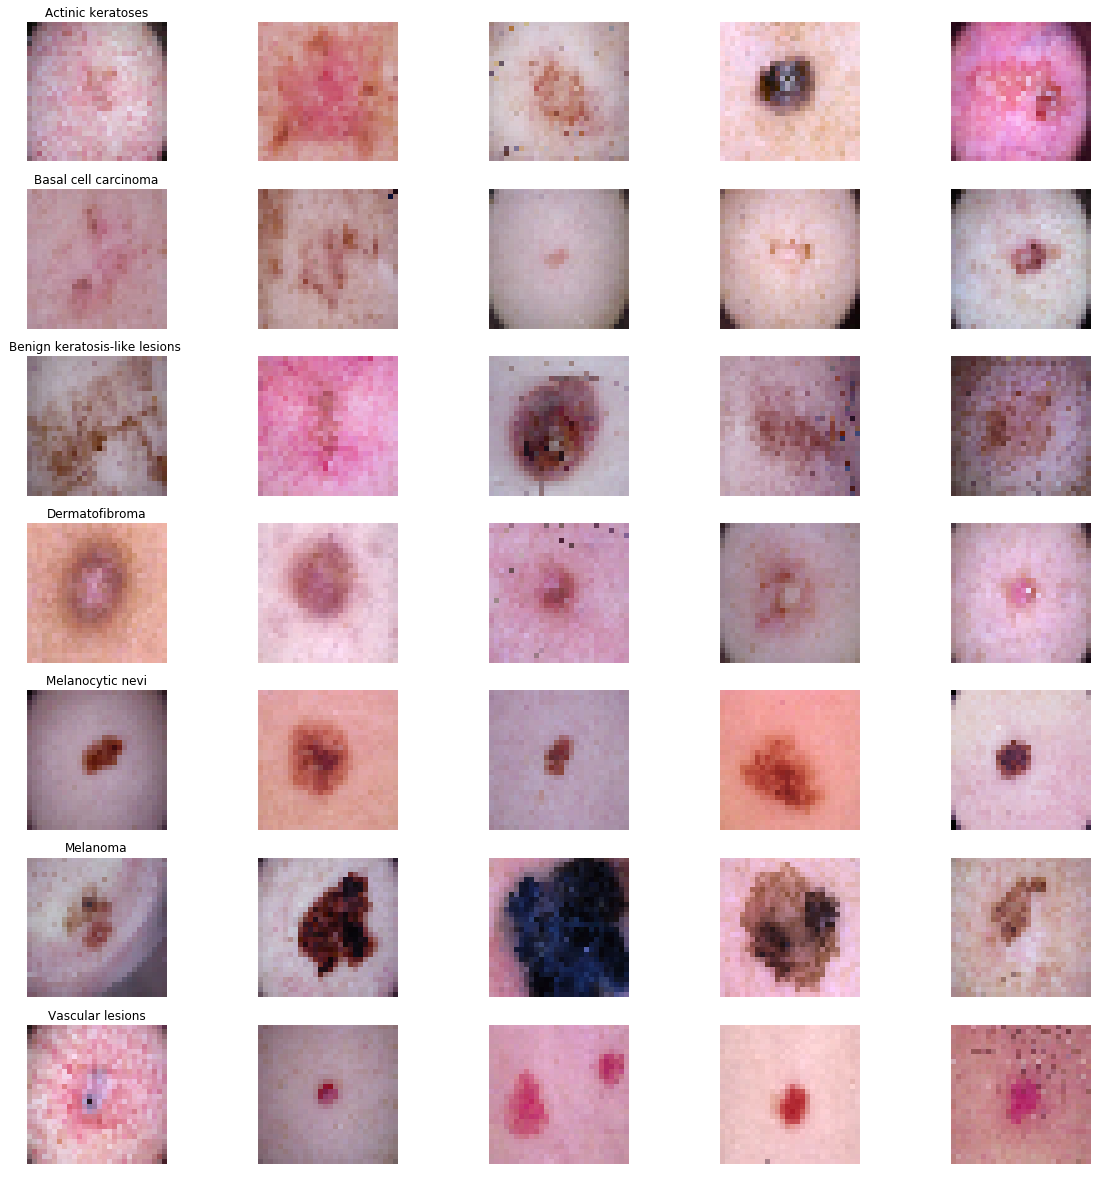

In [24]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_data.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=6542).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [25]:
# Checking the image size distribution
skin_data['image'].map(lambda x: x.shape).value_counts()
#Selected 28 x 37 to keep the aspect ratio and see if there is an improvement

(28, 28, 3)    10015
Name: image, dtype: int64

In [10]:
input_shape = (28, 28, 3)
num_classes = 7
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),
    
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.55),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

**Learning Rate Reduction**
The learning rate refers to how quickly the model can be adapted to the problem. It is a method update the weights during training. Depending on the size, the epochs need to be adjusted accordingly because smaller learning rates make smaller changes, thus need more epochs, while large learning rates result in rapid changes, thus need fewer epochs. 

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  
datagen.fit(X_train)

**Image Data Augmentation**
A problem with this dataset includes the overfitting of one class. Therefore, in order to combat this I wanted to used ImageDataGenerator, a function in keras, which takes a batch of training images and applies transformations (i.e., rotation, zoom, shifts). After these transformations are completed, this function returns the original data and the transformed data. 
randomly transforming it, and then returning the transformed data, which is used to train the CNN.

In [13]:
epochs = 50 
batch_size = 100
history = model.fit_generator(
    datagen.flow(X_train,y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_validate,y_validate),
    validation_steps=X_validate.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction]
)

Epoch 1/50
72/72 [==============================] - 13s 184ms/step - loss: 0.2470 - accuracy: 0.9047 - val_loss: 0.2365 - val_accuracy: 0.9065
Epoch 2/50
72/72 [==============================] - 12s 163ms/step - loss: 0.2277 - accuracy: 0.9128 - val_loss: 0.2271 - val_accuracy: 0.9118
Epoch 3/50
72/72 [==============================] - 12s 163ms/step - loss: 0.2238 - accuracy: 0.9161 - val_loss: 0.2136 - val_accuracy: 0.9177
Epoch 4/50
72/72 [==============================] - 12s 164ms/step - loss: 0.2141 - accuracy: 0.9192 - val_loss: 0.2054 - val_accuracy: 0.9197
Epoch 5/50
72/72 [==============================] - 12s 168ms/step - loss: 0.2095 - accuracy: 0.9185 - val_loss: 0.2023 - val_accuracy: 0.9202
Epoch 6/50
72/72 [==============================] - 13s 177ms/step - loss: 0.2066 - accuracy: 0.9198 - val_loss: 0.2110 - val_accuracy: 0.9170
Epoch 7/50
72/72 [==============================] - 13s 183ms/step - loss: 0.2027 - accuracy: 0.9210 - val_loss: 0.2013 - val_accuracy: 0.9190

In [27]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
#Somehow it improved using the validation train and test that was randomly split
#Early stopping was not good, reduced learning rate better

2003/2003 [==============================] - 2s 750us/step
Test: accuracy = 0.935026  ;  loss = 0.157238
